In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
seed = 17
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, precision_score

import numpy as np # Numpy: biblioteca para manipular vetores e matrizes
import pandas as pd # Pandas: biblioteca para manipular tabelas
import scipy.stats as ss
from sklearn.metrics import confusion_matrix

from collections import Counter
import seaborn as sns
import time

# Detecção de Drones Invasores

#### Carregando dataset UPLINK

In [88]:
lista = ['V1_size','V2_size','V3_size','V4_size','V5_size','V6_size','V7_size','V8_size','V9_size','V1_interval','V2_interval','V3_interval','V4_interval','V5_interval','V6_interval','V7_interval','V8_interval','V9_interval','classe']

test = []
train = []

for i in range(4,7):
    test.append(pd.read_csv(f'./dataset/dataset{i}_teste.csv', sep = ',', names=lista)) 
    train.append(pd.read_csv(f'./dataset/dataset{i}_treino.csv', sep = ',', names=lista))
    print(f"Tamanho df teste {i}: ",len(test[-1]))
    print(f"Tamanho df treino {i} : ",len(train[-1]))

frames = train + test
df_train1 = pd.concat(frames)

Tamanho df teste 4:  1063
Tamanho df treino 4 :  10600
Tamanho df teste 5:  1351
Tamanho df treino 5 :  13513
Tamanho df teste 6:  7
Tamanho df treino 6 :  66


In [89]:
print(df_train1.shape)

(26600, 19)


In [90]:
from sklearn.utils import shuffle

df_train1 = shuffle(df_train1, random_state=17)
df_train1.describe()

,V1_size,V2_size,V3_size,V4_size,V5_size,V6_size,V7_size,V8_size,V9_size,V1_interval,V2_interval,V3_interval,V4_interval,V5_interval,V6_interval,V7_interval,V8_interval,V9_interval,classe
count,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000,26600.000000
mean,0.141266,0.832086,0.009193,0.005372,4.011593,23.125526,7.508702,0.000078,0.844952,746.753970,351.672967,863.509718,97.516951,-0.505342,4.656437,1121.276617,167.100639,842.833428,0.532744
std,2.353076,21.394521,0.591686,0.048497,2.260586,23.724306,213.352046,0.000142,21.416791,514.239823,264.507727,657.756101,192.386003,2.234050,14.106052,658.179769,151.656506,550.832146,0.498936
min,0.000056,0.000044,0.000001,0.000000,-1.931900,-1.980700,0.000245,0.000000,0.000114,63.520000,0.200000,62.000000,0.000000,-9.702000,-2.019900,68.000000,61.000000,63.981000,0.000000
25%,0.001347,0.002471,0.000118,0.000077,2.323050,5.767325,0.016589,0.000002,0.002862,123.147500,40.376000,138.000000,0.000000,-1.015850,-1.272300,183.000000,76.000000,130.640000,0.000000
50%,0.003324,0.008194,0.000331,0.000177,3.463700,13.738000,0.047707,0.000006,0.009312,866.255000,359.490000,1166.000000,0.000000,-0.331555,1.175900,1502.000000,76.000000,1083.400000,1.000000
75%,0.012163,0.026665,0.000895,0.000813,5.484175,33.710000,0.151465,0.000121,0.028944,1141.125000,618.950000,1476.000000,112.680000,0.580743,2.248975,1610.000000,222.000000,1285.500000,1.000000
max,149.870000,1492.400000,68.171000,3.941900,9.849300,98.010000,14925.000000,0.008234,1492.500000,1675.700000,761.070000,1676.000000,1136.400000,9.849400,98.010000,3468.000000,1676.000000,1675.700000,1.000000


In [91]:
# verifica duplicados
df_train_noduplicates = df_train1.drop_duplicates()
y= df_train_noduplicates.classe.to_numpy()

print(f'Resultante com duplicados {df_train1.shape}')
print(f'Resultante sem duplicados {df_train_noduplicates.shape}')
print(f'Total de valores duplicados: {df_train_noduplicates.shape[0]-df_train1.shape[0]}')

X_nodupl = df_train_noduplicates
X_nodupl = X_nodupl.drop(['classe'], axis=1)



print(Counter(y))


Resultante com duplicados (26600, 19)
Resultante sem duplicados (23181, 19)
Total de valores duplicados: -3419
Counter({1: 14171, 0: 9010})


In [92]:
# Substituindo valores nulos por media
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=0, strategy='mean')
imp_mean = imp_mean.fit_transform(X_nodupl)
X_nodupl = pd.DataFrame(imp_mean, columns=X_nodupl.columns, index=X_nodupl.index)


In [93]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Normalização por amplitude utilizando Reescala
from pca import pca

scaler = MinMaxScaler()
model = pca(detect_outliers=['ht2'], normalize=False)
          

## Com pca
analisis_pca = model.fit_transform(X_nodupl)


def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [18] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]


In [94]:
print(analisis_pca['outliers'])

        y_proba   y_score  y_bool
454    0.300341  7.227262   False
6798   0.145044  9.547552   False
2812   0.676717  3.999697   False
10244  0.717777  3.695693   False
8926   0.822094  2.893469   False
...         ...       ...     ...
675    0.741750  3.516676   False
406    0.298687  7.246090   False
3102   0.718479  3.690475   False
2191   0.297475  7.259948   False
263    0.793890  3.118062   False

[23181 rows x 3 columns]


In [58]:
# RETIRANDO OUTLIERS

# Select the outliers
#Xoutliers = df_train_noduplicates[analisis_pca['outliers']['y_bool']]
Xoutliers = df_train_noduplicates[analisis_pca['outliers']['y_bool']]
Xoutliers.shape
# Select the other set
Xnormal = df_train_noduplicates[~analisis_pca['outliers']['y_bool']]
print(f'Identificados: {Xoutliers.shape[0]} outliers')

ynormal = df_train_noduplicates.classe.to_numpy()
Xnormal = df_train_noduplicates.drop(['classe'], axis=1)


Identificados: 36 outliers


In [98]:
# normalizando dataset sem outliers
# Com normalização
#normalizado = scaler.fit_transform(Xnormal)
normalizado = scaler.fit_transform(X_nodupl)
normalizado = pd.DataFrame(normalizado, columns=Xnormal.columns, index=Xnormal.index)

In [99]:
print(analisis_pca['topfeat'])

      PC      feature   loading  type
0    PC1  V7_interval  0.540343  best
1    PC2  V7_interval  0.683298  best
2    PC3  V8_interval  0.517782  best
3    PC4      V7_size  0.974858  best
4    PC5  V4_interval  0.955319  best
5    PC6  V8_interval  0.659070  best
6    PC7  V2_interval -0.672747  best
7    PC8      V6_size  0.990244  best
8    PC9  V6_interval  0.739522  best
9   PC10  V6_interval  0.668764  best
10  PC11  V5_interval -0.995546  best
11  PC12      V1_size  0.589615  best
12  PC13      V3_size  0.663878  best
13  PC14      V5_size  0.962186  best
14  PC15      V1_size  0.675269  best
15  PC16      V4_size  0.961631  best
16  PC17      V9_size  0.679317  best
17  PC18      V8_size  1.000000  best
18  PC17      V2_size -0.673826  weak
19  PC10  V1_interval  0.481785  weak
20   PC1  V3_interval  0.531484  weak
21  PC10  V9_interval -0.503661  weak


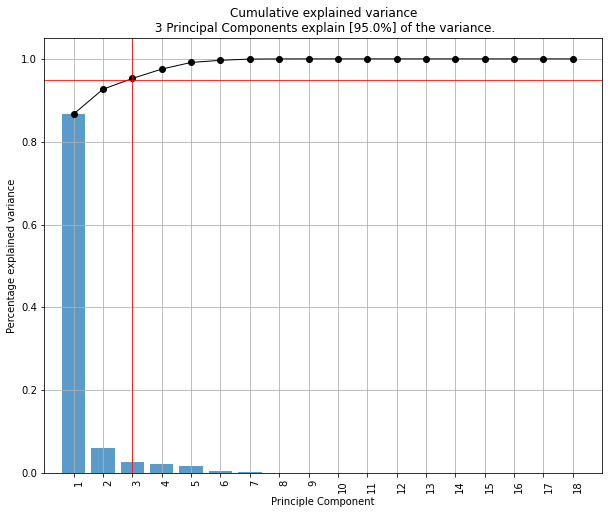

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 3 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [49]:
model.plot()


In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_features = SelectKBest(chi2, k = 3)
x_Kbest_features = chi2_features.fit_transform(normalizado,ynormal)


In [101]:
normalizado.var()

V1_size        0.000197
V2_size        0.000163
V3_size        0.000043
V4_size        0.000111
V5_size        0.036291
V6_size        0.054959
V7_size        0.000162
V8_size        0.000230
V9_size        0.000164
V1_interval    0.099641
V2_interval    0.129503
V3_interval    0.166970
V4_interval    0.021103
V5_interval    0.011304
V6_interval    0.017157
V7_interval    0.039650
V8_interval    0.007857
V9_interval    0.118169
dtype: float64

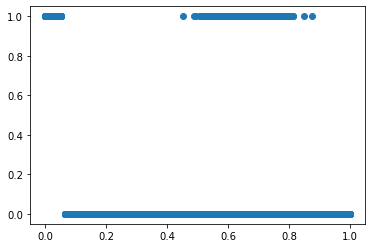

In [102]:
from matplotlib import pyplot
pyplot.scatter(normalizado['V9_interval'], ynormal)
pyplot.show()

In [103]:
normalizado = variance_threshold_selector(normalizado, 0.09) 
#normalizado = normalizado.drop(['V1_size','V2_size','V4_size','V5_size','V7_size','V8_size','V1_interval','V3_interval','V7_interval'], axis=1)
normalizado.describe()

,V1_interval,V2_interval,V3_interval,V9_interval
count,23181.000000,23181.000000,23181.000000,23181.000000
mean,0.397010,0.456952,0.475996,0.457080
std,0.315660,0.359866,0.408619,0.343758
min,0.000000,0.000000,0.000000,0.000000
25%,0.033818,0.051499,0.047088,0.038244
50%,0.481150,0.461537,0.568773,0.616745
75%,0.616544,0.826856,0.876084,0.734135
max,1.000000,1.000000,1.000000,1.000000


In [104]:
normalizado.shape, ynormal.shape
y=ynormal
#normalizado.shape, y.shape

### Balanceando

In [105]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_balanced, y_balanced = undersample.fit_resample(normalizado, y)
from collections import Counter
print(Counter(y_balanced))

Counter({0: 9010, 1: 9010})


### Normalizando por padronização



In [20]:
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = StandardScaler()
#Xstd = scaler.fit_transform(X_balanced)
#df_balanced_stand = pd.DataFrame(Xstd, columns=X_balanced.columns, index=X_balanced.index)

In [21]:
#Xstd_validation = scaler.fit_transform(X_validation)
#df_validation = pd.DataFrame(Xstd_validation, columns=X_validation.columns, index=X_validation.index)

In [106]:
# training dataset
X = X_balanced
y = y_balanced

print(f'X:{X.shape} y:{y.shape} ')


X:(18020, 4) y:(18020,) 


In [107]:
from sklearn.model_selection import train_test_split
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

print(f'X_train:{X_train.shape} y_train:{y_train.shape} ')
print(Counter(y_train))
print(f'X_test:{X_test.shape} y_test:{y_test.shape} ')
print(Counter(y_test))

X_train:(9010, 4) y_train:(9010,) 
Counter({0: 4530, 1: 4480})
X_test:(9010, 4) y_test:(9010,) 
Counter({1: 4530, 0: 4480})


### Testing with knn 



In [108]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

knn3 = KNeighborsClassifier(n_neighbors=2) 

print('Fitting data')
knn3.fit(X_train, y_train)
print('Predicting data')
ypredicted = knn3.predict(X_test)
print(np.count_nonzero(y_test == ypredicted), f"out of {ypredicted.shape}")


Fitting data
Predicting data
8913 out of (9010,)


In [109]:
print(f' KNN: acuracia: {accuracy_score(ypredicted, y_test)}  Precisão :{precision_score(ypredicted, y_test)}')

 KNN: acuracia: 0.9892341842397336  Precisão :0.9856512141280354


In [76]:
confusion_matrix(y_test, ypredicted)

array([[4448,   32],
       [  64, 4466]])

## Grid Seach em nas tecnicas de classificação
### Redes neurais
### Arvore de decisão
### Bigtree
### KNN
### Naive Bayes
### svmlinear
### svmrbf


In [77]:
scorer = make_scorer(precision_score) # Teste outras

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

gscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

algorithms = {
    'NeuNet': GridSearchCV(
        Pipeline([(
            'nn', MLPClassifier( solver='adam', early_stopping=True, random_state=seed,  max_iter=1000 ))]), 
        param_grid={
            'nn__activation': ['relu', 'tanh'],
            'nn__hidden_layer_sizes': [(30, 2), (35, 2)],
            'nn__validation_fraction': [0.1, 0.5, 0.6],
        },
        scoring=scorer,
        cv=gscv),
    
    'tree':  GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            ('tree', DecisionTreeClassifier(random_state=seed))]), 
        param_grid={
            'tree__max_depth': [2, 4, 5],
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=scorer,
        cv=gscv),
    
    'bigtree':  GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            ('tree', DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=seed))]), 
        param_grid={
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=scorer,
        cv=gscv),
    'kNN':  GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            #('scaler', MinMaxScaler(feature_range=(0, 1))),
            ('selector', VarianceThreshold()),
            ('knn', KNeighborsClassifier())]), 
        param_grid={
            'selector__threshold': [0, 0.01, 0.02, 0.03],
            'knn__n_neighbors': [1, 3, 5],
            'knn__p': [1, 2],
        },
        scoring=scorer,
        cv=gscv),
    'nb': GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            ('selector', SelectKBest()),
            ('nb', GaussianNB())]), 
        param_grid={
            'selector__k': [3, 5, 10],
        },
        scoring=scorer,
        cv=gscv),
    'svmlinear': GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            #('scaler', StandardScaler()),
            #('pca', PCA()),
            ('svm', SVC(kernel='linear', random_state=seed))]), 
        param_grid={
            #'pca__n_components': [2, 5, 10],
            'svm__C': [1.0, 2.0],
        },
        scoring=scorer,
        cv=gscv),
    'svmrbf': GridSearchCV(
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            #('scaler', StandardScaler()),
            #('pca', PCA(random_state=seed)),
            ('svm', SVC(kernel='rbf', random_state=seed))]), 
        param_grid={
            #'pca__n_components': [2, 5, 10],
            'svm__C': [1.0, 2.0],
            'svm__gamma': [0.1, 1.0, 2.0],
        },
        scoring=scorer,
        cv=gscv),

    
}

In [78]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
# df_balanced_stand, y_balanced 
result = {}
result_score = {}
i = 1
# X_train, X_test, y_train, y_test

for alg, clf in algorithms.items():
    start = time.time()
    print(f'Training with algorithm {i}: {alg}')
    i += 1
    result[alg] = cross_val_predict(clf, X_train, y_train, n_jobs= -1,  cv=gscv)
    #result_score[alg] = cross_val_score(clf, X, y)
    print(f'acuracia:{accuracy_score(y_train,result[alg]) }, precisão : {precision_score(y_train,result[alg]) } ')
    #print(result[alg])
    print(f"it took {time.time() - start:.2f} seconds.")

Training with algorithm 1: NeuNet
acuracia:0.7457269700332964, precisão : 0.9227500965623793 
it took 37.57 seconds.
Training with algorithm 2: tree
acuracia:0.9637069922308547, precisão : 0.9466551946655195 
it took 5.35 seconds.
Training with algorithm 3: bigtree
acuracia:0.9855715871254163, precisão : 0.9848417298261257 
it took 0.55 seconds.
Training with algorithm 4: kNN
acuracia:0.9912319644839068, precisão : 0.9888913574761165 
it took 25.82 seconds.
Training with algorithm 5: nb
acuracia:0.6066592674805772, precisão : 0.6204323211528564 
it took 0.84 seconds.
Training with algorithm 6: svmlinear
acuracia:0.9196448390677026, precisão : 0.897712833545108 
it took 11.02 seconds.
Training with algorithm 7: svmrbf
acuracia:0.979023307436182, precisão : 0.9648970747562297 
it took 34.73 seconds.


In [79]:
for alg, clf in algorithms.items():
    print(f'{alg}:  precision:{precision_score(y_train,result[alg])}, accuracy_score: {accuracy_score(y_train,result[alg])}, f1_score: {f1_score(y_train,result[alg])}  ')

NeuNet:  precision:0.9227500965623793, accuracy_score: 0.7457269700332964, f1_score: 0.6759088980053756  
tree:  precision:0.9466551946655195, accuracy_score: 0.9637069922308547, f1_score: 0.9641800854419982  
bigtree:  precision:0.9848417298261257, accuracy_score: 0.9855715871254163, f1_score: 0.9855007807271916  
kNN:  precision:0.9888913574761165, accuracy_score: 0.9912319644839068, f1_score: 0.9912036521545485  
nb:  precision:0.6204323211528564, accuracy_score: 0.6066592674805772, f1_score: 0.5763805880946689  
svmlinear:  precision:0.897712833545108, accuracy_score: 0.9196448390677026, f1_score: 0.9213214518582916  
svmrbf:  precision:0.9648970747562297, accuracy_score: 0.979023307436182, f1_score: 0.9792193512919186  


In [117]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
# df_balanced_stand, y_balanced 
result = {}
result_score = {}
i = 1
# X_train, X_test, y_train, y_test

for alg, clf in algorithms.items():
    start = time.time()
    print(f'Training with algorithm {i}: {alg}')
    i += 1
    #result[alg] = cross_val_predict(clf, X, y, n_jobs= -1,  cv=gscv)
    result_score[alg] = cross_validate(clf, X, y, n_jobs= -1,  cv=gscv, scoring = 'precision')
    #print(f'acuracia:{accuracy_score(y_train,result[alg]) } ')
    print(result_score[alg])
    print(f"it took {time.time() - start} seconds.")

Training with algorithm 1: NeuNet
{'fit_time': array([112.04108095, 119.67561698, 104.75211811]), 'score_time': array([0.0139811 , 0.01470327, 0.01229382]), 'test_score': array([0.99565217, 0.9938763 , 0.67086835])}
it took 119.75746083259583 seconds.
Training with algorithm 2: tree
{'fit_time': array([1.35916185, 1.42963314, 1.36660886]), 'score_time': array([0.02398682, 0.00714684, 0.00801301]), 'test_score': array([0.95089431, 0.94983607, 0.94263616])}
it took 1.4690921306610107 seconds.
Training with algorithm 3: bigtree
{'fit_time': array([0.48221803, 0.51970577, 0.52848387]), 'score_time': array([0.00931668, 0.00591111, 0.00450921]), 'test_score': array([0.98311258, 0.99228188, 0.98774023])}
it took 0.5643537044525146 seconds.
Training with algorithm 4: kNN
{'fit_time': array([23.85956502, 23.88045216, 23.49767709]), 'score_time': array([0.33870482, 0.33629274, 0.42914414]), 'test_score': array([0.98779683, 0.99168053, 0.9897351 ])}
it took 24.234888792037964 seconds.
Training wi

In [131]:
for alg, clf in algorithms.items():
     print(f'{alg}: Resultado precisão:  {result_score[alg]["test_score"]} media:{result_score[alg]["test_score"].mean():.4f} std:{result_score[alg]["test_score"].std():0.4f} ')

NeuNet: Resultado precisão:  [0.99565217 0.9938763  0.67086835] media:0.8868 std:0.1527 
tree: Resultado precisão:  [0.95089431 0.94983607 0.94263616] media:0.9478 std:0.0037 
bigtree: Resultado precisão:  [0.98311258 0.99228188 0.98774023] media:0.9877 std:0.0037 
kNN: Resultado precisão:  [0.98779683 0.99168053 0.9897351 ] media:0.9897 std:0.0016 
nb: Resultado precisão:  [0.61442598 0.6344294  0.62190004] media:0.6236 std:0.0083 
svmlinear: Resultado precisão:  [0.90422444 0.91159513 0.89984152] media:0.9052 std:0.0048 
svmrbf: Resultado precisão:  [0.97076023 0.97076023 0.96950032] media:0.9703 std:0.0006 


In [112]:
for alg, clf in algorithms.items():
    print(f'{alg}:  precision:{precision_score(y,result[alg])}, accuracy_score: {accuracy_score(y,result[alg])}, f1_score: {f1_score(y,result[alg])}  ')

NeuNet:  precision:0.8104158363225721, accuracy_score: 0.7593229744728079, f1_score: 0.737739614198464  
tree:  precision:0.947767663632423, accuracy_score: 0.9586015538290789, f1_score: 0.9590963921482619  
bigtree:  precision:0.9876912840984697, accuracy_score: 0.9881243063263041, f1_score: 0.988129576214777  
kNN:  precision:0.9897316992381583, accuracy_score: 0.9922863485016649, f1_score: 0.9923064150107931  
nb:  precision:0.6235039470333588, accuracy_score: 0.6076581576026637, f1_score: 0.5807637571157495  
svmlinear:  precision:0.9052036681595222, accuracy_score: 0.9217536071032186, f1_score: 0.9233195562323254  
svmrbf:  precision:0.9703399004113444, accuracy_score: 0.9822419533851277, f1_score: 0.982463831652784  


{'NeuNet': array([0, 0, 1, ..., 1, 0, 1]),
 'tree': array([0, 0, 0, ..., 1, 1, 1]),
 'bigtree': array([0, 0, 0, ..., 1, 1, 1]),
 'kNN': array([0, 0, 0, ..., 1, 1, 1]),
 'nb': array([0, 0, 1, ..., 1, 0, 1]),
 'svmlinear': array([0, 0, 0, ..., 1, 1, 1]),
 'svmrbf': array([0, 0, 0, ..., 1, 1, 1])}

In [132]:
result = pd.DataFrame.from_dict(result)

result

""


In [714]:
for alg, clf in algorithms.items():
    print(clf)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('nn',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=1000,
                                                      random_state=17))]),
             param_grid={'nn__activation': ['relu', 'tanh'],
                         'nn__hidden_layer_sizes': [(30, 2), (35, 2)],
                         'nn__validation_fraction': [0.1, 0.5, 0.6]},
             scoring=make_scorer(precision_score))
GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=17))]),
             param_grid={'tree__criterion': ['entropy', 'gini'],
                         'tree__max_depth': [2, 4, 5]},
             scoring=make_scorer(precision_score))
GridSearchCV(cv=Stratified

In [715]:
def phi(a, b, expected):
    errors = np.logical_or(a != expected, b != expected)
    
    return np.count_nonzero(np.logical_and(a == b, errors)) / np.count_nonzero(errors)


# X_balanced, y_balanced
correrrors = np.ones((len(algorithms), len(algorithms)))

for i in range(len(algorithms)):
    for j in range(i + 1, len(algorithms)):
        correrrors[i, j] = phi(result[result.columns[i]], result[result.columns[j]], y)
        correrrors[j, i] = correrrors[i, j]    
        
print(correrrors)

[[1.         0.0302521  0.02399077 0.01177829 0.57837456 0.09637625
  0.01309365]
 [0.0302521  1.         0.14044213 0.12654746 0.01984712 0.13024987
  0.34993271]
 [0.02399077 0.14044213 1.         0.37743191 0.01463692 0.07092199
  0.23394495]
 [0.01177829 0.12654746 0.37743191 1.         0.00725359 0.05045872
  0.25      ]
 [0.57837456 0.01984712 0.01463692 0.00725359 1.         0.10950932
  0.00804661]
 [0.09637625 0.13024987 0.07092199 0.05045872 0.10950932 1.
  0.11967419]
 [0.01309365 0.34993271 0.23394495 0.25       0.00804661 0.11967419
  1.        ]]


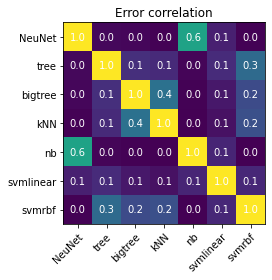

In [716]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(correrrors)

ax.set_xticks(np.arange(len(result.columns)))
ax.set_yticks(np.arange(len(result.columns)))
ax.set_xticklabels(result.columns)
ax.set_yticklabels(result.columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(result.columns)):
    for j in range(len(result.columns)):
        text = ax.text(j, i, round(correrrors[i, j], 1),
                       ha="center", va="center", color="w")

ax.set_title("Error correlation")
fig.tight_layout()
plt.show()

## Todos são melhores que a média?

In [717]:
# random classifier
mode = lambda x: ss.mode(x).mode[0]
random = np.mean(mode(y) == y)
print(random)

0.5


In [718]:
result.apply(lambda ypred: np.mean(ypred == y))

NeuNet       0.765094
tree         0.962764
bigtree      0.988568
kNN          0.991787
nb           0.615205
svmlinear    0.919256
svmrbf       0.981576
dtype: float64

## Combinando classificadores

In [719]:
result['kNN+tree+svmrbf'] = result.filter(['kNN', 'tree', 'svmrbf']).apply(mode, axis=1)
result['nb+svmlinear+svmrbf'] = result.filter(['nb', 'svmlinear', 'svmrbf']).apply(mode, axis=1)
result['kNN+bigtree+svmrbf'] = result.filter(['kNN', 'bigtree', 'svmrbf']).apply(mode, axis=1)

In [720]:
result.apply(lambda ypred: np.mean(ypred == y))

NeuNet                 0.765094
tree                   0.962764
bigtree                0.988568
kNN                    0.991787
nb                     0.615205
svmlinear              0.919256
svmrbf                 0.981576
kNN+tree+svmrbf        0.984462
nb+svmlinear+svmrbf    0.944895
kNN+bigtree+svmrbf     0.992064
dtype: float64

**nota**: podem existir outros casos de melhoras/pioras.

# Bagging, boosting, etc

In [409]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [546]:
algorithms = {
    'bagging':  
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            ('tree', BaggingClassifier(random_state=seed))]),
    'forest':  
        Pipeline([
            #('imputer', SimpleImputer(strategy='mean')),
            ('tree', RandomForestClassifier(random_state=seed))]),
    #'kNN+tree+svmrbf':
    #    VotingClassifier([ ])
    # Testar outros
}

In [548]:
from sklearn.model_selection import cross_val_predict

for alg, clf in algorithms.items():
  result[alg] = cross_val_predict(clf, X, y, cv=cv)

In [549]:
result.apply(lambda ypred: np.mean(ypred == y))

NeuNet                 0.963707
tree                   0.984628
bigtree                0.996115
kNN                    0.993951
nb                     0.670644
svmlinear              0.962209
svmrbf                 0.986848
kNN+tree+svmrbf        0.993618
nb+svmlinear+svmrbf    0.977358
kNN+bigtree+svmrbf     0.995339
bagging                0.996615
forest                 0.998391
dtype: float64

In [550]:
result

,NeuNet,tree,bigtree,kNN,nb,svmlinear,svmrbf,kNN+tree+svmrbf,nb+svmlinear+svmrbf,kNN+bigtree+svmrbf,bagging,forest
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18015,1,1,1,1,0,1,1,1,1,1,1,1
18016,1,1,1,1,1,1,1,1,1,1,1,1
18017,1,1,1,1,1,1,1,1,1,1,1,1
18018,1,1,1,1,0,1,1,1,1,1,1,1


### Rede neural
X_train, X_test, y_train, y_test
X_balanced_both, y_balanced_both

In [60]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [61]:
model_NN = MLPClassifier(hidden_layer_sizes=(30, 2),
                      activation='relu',
                      solver='adam',
                      max_iter=1000,
                      random_state=15,
                      early_stopping=True,
                      #verbose= True,
                      validation_fraction=0.1)

In [62]:
model_NN.fit(X_train, y_train)
ypredicted = model_NN.predict(X_test)
print(f'precision:{precision_score(ypredicted,y_test)}, accuracy_score: {accuracy_score(ypredicted,y_test)}, f1_score: {f1_score(ypredicted,y_test)}  ')

precision:0.9706401766004416, accuracy_score: 0.9658157602663707, f1_score: 0.966161283234454  


In [63]:
confusion_matrix(y_test, ypredicted)

array([[4305,  175],
       [ 133, 4397]])

In [64]:
tn, fp, fn, tp =  confusion_matrix(y_test, ypredicted).ravel()
(tn, fp, fn, tp)

(4305, 175, 133, 4397)

In [65]:
precision = (tp)/(tp+fp)
precision

0.9617235345581803

In [66]:
revocacao = tp/(tp+fn)
revocacao

0.9706401766004416

In [67]:
especificidade = tn/(tn+fp)
especificidade

0.9609375

In [68]:
confusion_matrix(y_test, ypredicted)

array([[4305,  175],
       [ 133, 4397]])

In [69]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, ypredicted)

0.9316663742274219

In [70]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

gscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
gscv

StratifiedKFold(n_splits=3, random_state=17, shuffle=True)

In [37]:
scores = cross_validate(model_NN, X, y, n_jobs=-1, cv = gscv, scoring='precision')

In [38]:
scores

{'fit_time': array([4.364856  , 3.86065626, 4.51753807]),
 'score_time': array([0.00653696, 0.01131582, 0.0058341 ]),
 'test_score': array([0.96038296, 0.95958279, 0.95993485])}

In [39]:
print("%0.4f precision with a standard deviation of %0.4f" % (scores['test_score'].mean(), scores['test_score'].std()))

0.9600 precision with a standard deviation of 0.0003


In [40]:
scores = cross_validate(model_NN, X, y, n_jobs=-1, cv = 5, scoring='precision')

In [41]:
scores

{'fit_time': array([4.85552001, 6.098423  , 4.97454309, 4.60470605, 5.5468049 ]),
 'score_time': array([0.00491643, 0.00906086, 0.00933981, 0.00955391, 0.00555301]),
 'test_score': array([0.96183206, 0.95276436, 0.95590637, 0.95892662, 0.96846112])}

In [42]:
print("%0.4f precision with a standard deviation of %0.4f" % (scores['test_score'].mean(), scores['test_score'].std()))

0.9596 precision with a standard deviation of 0.0054


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.6, random_state=0)
scores = cross_validate(model_NN, X, y, cv=cv,scoring='precision', n_jobs=-1)

print("%0.4f precision with a standard deviation of %0.4f" % (scores['test_score'].mean(), scores['test_score'].std()))

0.9568 precision with a standard deviation of 0.0106


## Decision Tree

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt = DecisionTreeClassifier(random_state=0, max_depth = 3, criterion= "gini")
decision_score = cross_val_score(dt, X, y, cv=10)

In [136]:
print("%0.4f precision with a standard deviation of %0.4f" % (decision_score.mean(), decision_score.std()))

0.9725 precision with a standard deviation of 0.0043


In [137]:
d_tree = dt.fit(X_train,y_train)

In [138]:
y_hat = d_tree.predict(X_test)

In [139]:
accuracy_score(y_hat,y_test)

0.96992230854606

In [132]:
f1_score(y_hat,y_test)

0.9767803577380292

In [133]:
confusion_matrix(y_test, y_hat)

array([[4405,   75],
       [ 134, 4396]])

[Text(265.8705882352941, 587.0880000000001, 'X[4] <= 0.066\ngini = 0.5\nsamples = 9010\nvalue = [4530, 4480]'),
 Text(78.7764705882353, 456.624, 'X[3] <= 0.001\ngini = 0.002\nsamples = 2446\nvalue = [2, 2444]'),
 Text(39.38823529411765, 326.1600000000001, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(118.16470588235295, 326.1600000000001, 'X[5] <= 0.727\ngini = 0.001\nsamples = 2445\nvalue = [1, 2444]'),
 Text(78.7764705882353, 195.69600000000003, 'gini = 0.0\nsamples = 2444\nvalue = [0, 2444]'),
 Text(157.5529411764706, 195.69600000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(452.964705882353, 456.624, 'X[3] <= 0.767\ngini = 0.428\nsamples = 6564\nvalue = [4528, 2036]'),
 Text(315.1058823529412, 326.1600000000001, 'X[3] <= 0.713\ngini = 0.066\nsamples = 3944\nvalue = [3809, 135]'),
 Text(236.3294117647059, 195.69600000000003, 'X[3] <= 0.675\ngini = 0.013\nsamples = 3519\nvalue = [3496, 23]'),
 Text(196.94117647058823, 65.23200000000008, 'gini = 0.002\nsamples = 3290\n

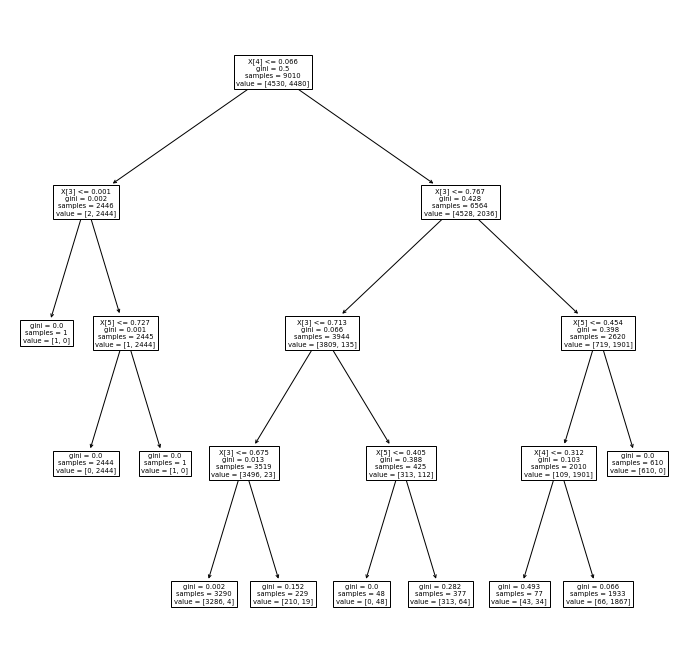

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(d_tree)  